In [1]:
import nbimport
from Aircraft_Kinematics import body_b, body_w, frame_i, frame_b, frame_w, bke, t, m, point_cm_w, \
    V_T, alpha, beta, sol_rot, sol_euler_rates, sol_vel_wind, P, Q, R, phi, theta, psi, M_bx, M_by, M_bz, \
    point_cm_b, M_wx, M_wy, M_wz, J_x, J_y, J_z, J_xz, sol_trans_wind, F_wx, F_wy, F_wz
import sympy
import scipy.optimize
import statespace
import pylab as pl
import control
g, L, C, D, T = sympy.symbols('g, L, C, D, T')
ail, elv, rdr, thr = sympy.symbols('ail, elv, rdr, thr')
%load_ext autoreload
%autoreload 2

importing IPython notebook from Aircraft Kinematics.ipynb


In [2]:
F = m*g*frame_i.z - L(t)*frame_w.z - C(t)*frame_w.y - D(t)*frame_w.x + T(t)*frame_b.x
F

g⋅m i_z - D w_x - C w_y - L w_z + T b_x

In [3]:
di_L_i = bke(body_w.linear_momentum(frame_i), frame_i, frame_w, t) 
sol_trans = sympy.solve((di_L_i - F).to_matrix(frame_w), [xi(t).diff(t) for xi in [V_T, alpha, beta]])
sol_trans

⎧                                                                             
⎨V_̇T: g⋅sin(α)⋅cos(φ)⋅cos(θ) + g⋅sin(β)⋅sin(φ)⋅cos(α)⋅cos(θ) - g⋅sin(θ)⋅cos(α
⎩                                                                             

           D   T⋅cos(α)⋅cos(β)      -g⋅m⋅sin(α)⋅sin(β)⋅sin(φ)⋅cos(θ) + g⋅m⋅sin
)⋅cos(β) - ─ + ───────────────, α̇: ──────────────────────────────────────────
           m          m                                                       

(α)⋅sin(θ)⋅cos(β) + g⋅m⋅cos(α)⋅cos(φ)⋅cos(θ) - m⋅P⋅V_T⋅sin(β) + m⋅Q⋅V_T⋅cos(β)
──────────────────────────────────────────────────────────────────────────────
                          m⋅V_T                                               

 - L - T⋅sin(α)⋅cos(β)      g⋅m⋅sin(β)⋅sin(θ) + g⋅m⋅sin(φ)⋅cos(β)⋅cos(θ) + m⋅P
──────────────────────, β̇: ──────────────────────────────────────────────────
                                                                              

⋅V_T⋅sin(α)⋅cos(β) + m⋅Q⋅V_T⋅sin(α)⋅sin(β) - m⋅R

In [4]:
M = frame_w.x*M_wx(t) + frame_w.y*M_wy(t) + frame_w.z*M_wz(t)

In [5]:
di_H_i = bke(body_b.angular_momentum(point_cm_b, frame_i), frame_i, frame_b, t)
di_H_i

(Jₓ⋅Ṗ + J_xz⋅Ṙ - J_y⋅Q⋅R + (J_xz⋅P + J_z⋅R)⋅Q) b_x + (J_y⋅Q̇ + (Jₓ⋅P + J_xz⋅R)⋅R - (J_xz⋅P + J_z⋅R)⋅P) b_y + (J_xz⋅Ṗ + J_y⋅P⋅Q + J_z⋅Ṙ - (Jₓ⋅P + J_xz⋅R)⋅Q) b_z

In [6]:
sol_rot = sympy.solve((M - di_H_i).to_matrix(frame_b), [xi(t).diff(t) for xi in [P, Q, R]])
sol_rot

⎧                                                                             
⎪    -(J_xz⋅(Jₓ⋅P⋅Q + J_xz⋅Q⋅R - J_y⋅P⋅Q + M_wx⋅sin(α) + M_wz⋅cos(α)) + J_z⋅(J
⎨Ṗ: ─────────────────────────────────────────────────────────────────────────
⎪                                                                             
⎩                                                                             

                                                                              
_xz⋅P⋅Q - J_y⋅Q⋅R + J_z⋅Q⋅R - M_wx⋅cos(α)⋅cos(β) + M_wy⋅sin(β) + M_wz⋅sin(α)⋅c
──────────────────────────────────────────────────────────────────────────────
             2                                                                
Jₓ⋅J_z - J_xz                                                                 

                              2         2                                     
os(β)))       -Jₓ⋅P⋅R + J_xz⋅P  - J_xz⋅R  + J_z⋅P⋅R + M_wx⋅sin(β)⋅cos(α) + M_w
────────, Q̇: ────────────────────────────────────

In [7]:
eoms = {}
eoms.update(sol_euler_rates)
eoms.update(sol_trans)
eoms.update(sol_vel_wind)
eoms.update(sol_rot)

x_vect = sympy.Matrix([Q, theta, V_T, alpha, P, R, phi, beta])
u_vect = sympy.Matrix([elv, thr, ail, rdr])
sub_no_t = {xi(t): xi for xi in x_vect}
f_vect = sympy.Matrix([eoms[xi(t).diff(t)].subs(sub_no_t) for xi in x_vect])
f_vect

⎡                                                 2         2                 
⎢                                 -Jₓ⋅P⋅R + J_xz⋅P  - J_xz⋅R  + J_z⋅P⋅R + M_wx
⎢                                 ────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                      Q⋅cos(φ
⎢                                                                             
⎢                                                                             
⎢                             g⋅sin(α)⋅cos(φ)⋅cos(θ) + g⋅sin(β)⋅sin(φ)⋅cos(α)⋅
⎢                                                                             
⎢                                                                             
⎢        -P⋅V_T⋅m⋅sin(β) + Q⋅V_T⋅m⋅cos(β) - g⋅m⋅sin(α)⋅sin(β)⋅sin(φ)⋅cos(θ) + 
⎢        ───────────────────────────────────────────

In [8]:
C_L_0, C_L_alpha, k_CD_CL, C_D_0, CL_CD_min, rho, S = \
sympy.symbols('C_L0 C_L_alpha k_CD_CL C_D_0 CL_CD_min, rho, S')
C_L = C_L_0 + C_L_alpha*alpha
C_D = C_D_0 + k_CD_CL*(C_L - CL_CD_min)**2
C_C = beta # todo
C_T = 10
C_l = -P -beta + ail
C_m = -Q -alpha + elv
C_n = -R -beta + rdr
q = rho*V_T**2/2
sub_aero_model = {
    L(t): C_L*q*S,
    D(t): C_D*q*S,
    C(t): C_C*q*S,
    T(t): C_T*thr,
    M_wx(t): C_l*q*S,# todo
    M_wy(t): C_m*q*S,# todo
    M_wz(t): C_n*q*S,# todo
}
sub_aero_model

⎧        2              2   ⎛                                             2⎞  
⎪   S⋅V_T ⋅β⋅ρ     S⋅V_T ⋅ρ⋅⎝C_D_0 + k_CD_CL⋅(-CL_CD_min + C_L0 + C_L_α⋅α) ⎠  
⎨C: ──────────, D: ─────────────────────────────────────────────────────────, 
⎪       2                                      2                              
⎩                                                                             

        2                                2                              2     
   S⋅V_T ⋅ρ⋅(C_L0 + C_L_α⋅α)        S⋅V_T ⋅ρ⋅(-P + ail - β)        S⋅V_T ⋅ρ⋅(-
L: ─────────────────────────, M_wx: ───────────────────────, M_wy: ───────────
               2                               2                              
                                                                              

                         2                            ⎫
Q - α + elv)        S⋅V_T ⋅ρ⋅(-R - β + rdr)           ⎪
────────────, M_wz: ───────────────────────, T: 10⋅thr⎬
2                              2        

In [9]:
f_aero_vect = f_vect.subs(sub_aero_model).applyfunc(lambda e:e.simplify())
f_aero_vect

⎡                                                                             
⎢                                                                        2    
⎢                                                        -Jₓ⋅P⋅R + J_xz⋅P  - J
⎢                                                                             
⎢                                                        ─────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                      2   ⎛                  
⎢                                                 S⋅V_T ⋅ρ⋅⎝C_D_0 + k_CD_CL⋅(-
⎢                                               - ────────────────────────────
⎢                                                   

In [10]:
param = f_aero_vect.atoms(sympy.Symbol).difference(x_vect)
param

set([CL_CD_min, C_D_0, C_L0, C_L_α, Jₓ, J_xz, J_y, J_z, S, ail, elv, g, k_CD_C
L, m, rdr, ρ, thr])

In [11]:
#x_id = sympy.Matrix(list(x_vect) + list(param))
#f_id_vect = sympy.Matrix(list(f_aero_vect) + list(sympy.zeros(len(param))))
#A_id = f_id_vect.jacobian(x_id)
#sub_x0 = {P:0, Q:0, R:0, phi:0, theta:0, alpha:0, beta:0}
#A_id.subs(sub_x0)

In [12]:
sub_const = {
    J_x:1, J_y:1, J_z:1, J_xz:0, m:1, rho:1.225, S:1, g:10,
    C_L_alpha:3, C_L_0: 0.1, C_D_0: 0.01, k_CD_CL: 0.01, CL_CD_min:0,
}

In [13]:
x_vect.T, u_vect.T

([Q  θ  V_T  α  P  R  φ  β], [elv  thr  ail  rdr])

In [14]:
def trim_level(V_T, gamma):
    f1 = lambda theta, elv, thr: \
        pl.sum(ss.f_eval(0, [0, theta, V_T, gamma-theta, 0, 0, 0, 0], [elv, thr, 0, 0])**2)
    res = scipy.optimize.minimize(lambda x:f1(theta=x[0], elv=x[1], thr=x[2]), [0,0,0])
    theta_trim = res.x[0]
    elv_trim = res.x[1]
    thr_trim = res.x[2]
    return [0, theta_trim, V_T, gamma - theta_trim, 0, 0, 0, 0], [elv_trim, thr_trim, 0, 0], res

([0, -0.0210165198052, 10, 0.0210165198052, 0, 0, 0, 0], [0.0210165158547, 0.0
208622649141, 0, 0])

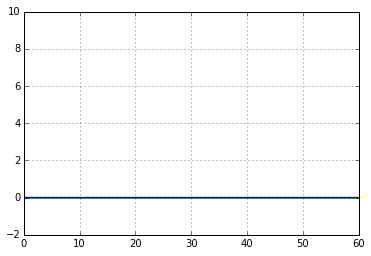

In [15]:
ss = statespace.StateSpace(x_vect, u_vect, f_aero_vect.subs(sub_const), x_vect)
x0, u0, res = trim_level(10, 0)
data = ss.simulate(x0, u0,dt=0.01,tf=60)
pl.plot(data.t, data.y);
pl.grid()
x0, u0

/usr/local/lib/python2.7/dist-packages/control/freqplot.py:124: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (omega == None):


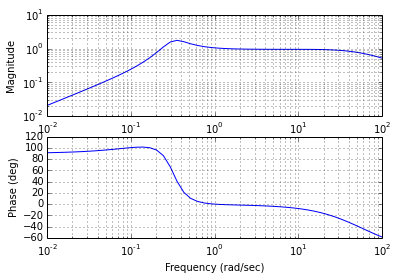

In [16]:
ss_lin = ss.linearize(x0, u0)
control.bode(ss_lin.to_control()[0,0], omega=pl.logspace(-2,2));

/usr/local/lib/python2.7/dist-packages/control/matlab.py:1136: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if klist == None:


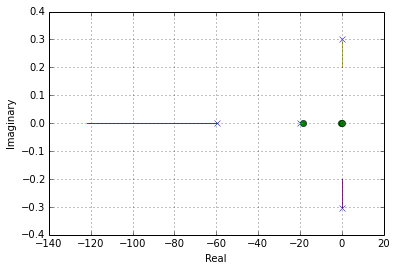

In [17]:
control.rlocus(ss_lin.to_control()[0,0], klist=pl.linspace(0,1,1000));
pl.grid()

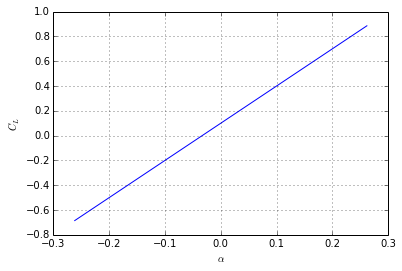

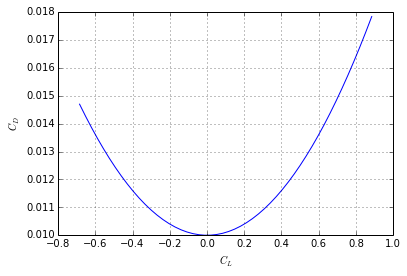

In [18]:
C_L_eval = sympy.lambdify(alpha, C_L.subs(sub_const))
C_D_eval = sympy.lambdify(alpha, C_D.subs(sub_const))
alpha_val = pl.linspace(-pl.deg2rad(15),pl.deg2rad(15))

pl.figure()
pl.plot(alpha_val, C_L_eval(alpha_val))
pl.xlabel(r'$\alpha$')
pl.ylabel(r'$C_L$')
pl.grid()

pl.figure()
pl.plot(C_L_eval(alpha_val), C_D_eval(alpha_val))
pl.xlabel(r'$C_L$')
pl.ylabel(r'$C_D$')
pl.grid()

In [19]:
K, S, E = control.lqr(ss_lin.A, ss_lin.B, pl.eye(8), pl.eye(4))
K

array([[  4.27207491e-01,   1.40960249e+00,  -3.63234788e-02,
         -2.77847846e-01,  -1.87645462e-15,   5.18727065e-16,
          2.65122637e-13,  -1.64429758e-14],
       [ -5.83372420e-03,  -9.13588777e-01,   9.80203674e-01,
          3.29354622e-01,  -5.13023866e-15,  -5.41326493e-15,
         -1.23539111e-13,  -5.87327967e-14],
       [ -1.86513919e-15,   1.96705345e-13,  -3.22048648e-14,
         -4.05437754e-14,   4.24717154e-01,   1.07270630e-02,
          9.21972736e-01,  -3.22774602e-01],
       [  5.58046153e-16,   1.39815527e-13,  -3.25151593e-14,
         -9.23180819e-15,  -7.00318492e-03,   4.18792501e-01,
          2.15362318e-02,  -3.94960394e-01]])

In [87]:
class Autopilot(object):
    """
    This class is a simple autopilot with an estimator and controller.
    """
    def __init__(self, x0, u0, f_eval, g_eval):
        self.time_contr = 0
        self.time_est = 0
        self.ode = scipy.integrate.ode(f_eval)

    def predict(self, t):
        self.ode.integrate(t)
        


In [20]:
def f_contr(t, y):
    x = y
    if 
    return u0-K.dot(x-x0)

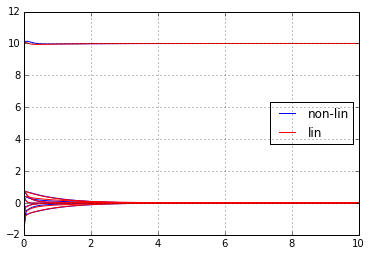

In [21]:
x1 = x0 + pl.rand(8)
data_lin = ss_lin.simulate(x1, u0, contr_eval=f_contr, dt=0.02)
data = ss.simulate(x1, u0, contr_eval=f_contr, dt=0.02)
h0 = pl.plot(data.t, data.x, 'b');
h1 = pl.plot(data_lin.t, data_lin.x, 'r');
pl.legend([h0[0], h1[0]], ['non-lin', 'lin'], loc='best')
pl.grid()

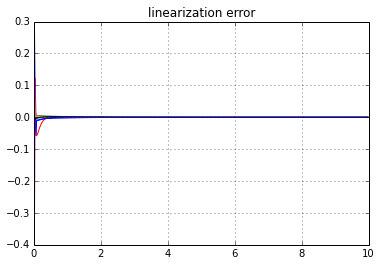

In [325]:
pl.plot(data.t, data_lin.x - data.x);
pl.title('linearization error')
pl.grid()

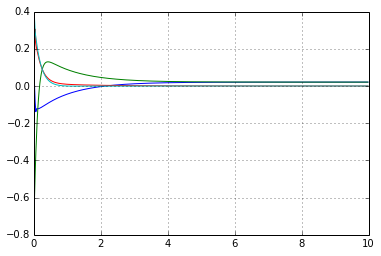

In [326]:
pl.plot(data.t, data.u);
pl.grid()

In [44]:
K_clean = pl.where(abs(K) < 1e-10, pl.zeros(K.shape), K)
K_clean

array([[ 0.42720749,  1.40960249, -0.03632348, -0.27784785,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.00583372, -0.91358878,  0.98020367,  0.32935462,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.42471715,
         0.01072706,  0.92197274, -0.3227746 ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.00700318,
         0.4187925 ,  0.02153623, -0.39496039]])

In [46]:
K_clean.T

array([[ 0.42720749, -0.00583372,  0.        ,  0.        ],
       [ 1.40960249, -0.91358878,  0.        ,  0.        ],
       [-0.03632348,  0.98020367,  0.        ,  0.        ],
       [-0.27784785,  0.32935462,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.42471715, -0.00700318],
       [ 0.        ,  0.        ,  0.01072706,  0.4187925 ],
       [ 0.        ,  0.        ,  0.92197274,  0.02153623],
       [ 0.        ,  0.        , -0.3227746 , -0.39496039]])

In [70]:
P_r, Q_r, R_r, k_P, k_Q, k_R, k_theta, k_phi, k_alpha = \
    sympy.symbols('P_r, Q_r, R_r, k_P, k_Q, k_R, k_theta, k_phi, k_alpha')

In [79]:
phi_r = k_P *(P_r - P)
ail_r = k_phi*(phi_r - phi)

theta_r = k_Q *(Q_r - Q)

elv_r = k_theta*(theta_r - theta) + k_alpha*(0-alpha)
rdr_r = k_R *(R_r - R)

thr_r = 0
u_r = sympy.Matrix([elv_r, thr_r, ail_r, rdr_r])
u_r

⎡-α⋅k_α + k_θ⋅(k_Q⋅(-Q + Qᵣ) - θ)⎤
⎢                                ⎥
⎢               0                ⎥
⎢                                ⎥
⎢     kᵩ⋅(k_P⋅(-P + Pᵣ) - φ)     ⎥
⎢                                ⎥
⎣         k_R⋅(-R + Rᵣ)          ⎦

In [80]:
u_vect

⎡elv⎤
⎢   ⎥
⎢thr⎥
⎢   ⎥
⎢ail⎥
⎢   ⎥
⎣rdr⎦

In [81]:
u_r = sympy.Matrix([elv_r, thr_r, ail_r, rdr_r])
u_r.jacobian(x_vect)

⎡-k_Q⋅k_θ  -k_θ  0  -k_α     0      0     0   0⎤
⎢                                              ⎥
⎢   0       0    0   0       0      0     0   0⎥
⎢                                              ⎥
⎢   0       0    0   0    -k_P⋅kᵩ   0    -kᵩ  0⎥
⎢                                              ⎥
⎣   0       0    0   0       0     -k_R   0   0⎦

In [82]:
x_vect

⎡ Q ⎤
⎢   ⎥
⎢ θ ⎥
⎢   ⎥
⎢V_T⎥
⎢   ⎥
⎢ α ⎥
⎢   ⎥
⎢ P ⎥
⎢   ⎥
⎢ R ⎥
⎢   ⎥
⎢ φ ⎥
⎢   ⎥
⎣ β ⎦

In [83]:
K_clean.T

array([[ 0.42720749, -0.00583372,  0.        ,  0.        ],
       [ 1.40960249, -0.91358878,  0.        ,  0.        ],
       [-0.03632348,  0.98020367,  0.        ,  0.        ],
       [-0.27784785,  0.32935462,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.42471715, -0.00700318],
       [ 0.        ,  0.        ,  0.01072706,  0.4187925 ],
       [ 0.        ,  0.        ,  0.92197274,  0.02153623],
       [ 0.        ,  0.        , -0.3227746 , -0.39496039]])

We want to identify the aerodynamic parameters. In order to do this, we must simultaneously estimate the states and the parameters.

In [86]:
data.y

array([[  1.79072567e-01,   7.55659726e-01,   1.00511222e+01, ...,
          3.24959553e-01,   4.31631874e-01,   8.29011512e-01],
       [ -1.37359861e+00,   7.45230282e-01,   1.00875639e+01, ...,
         -6.65222872e-01,   4.26513802e-01,   7.34697954e-01],
       [ -1.08887686e+00,   7.25630611e-01,   1.01158565e+01, ...,
         -3.36194190e-01,   3.97764953e-01,   6.55213778e-01],
       ..., 
       [ -4.67367353e-05,  -2.09690225e-02,   9.99999405e+00, ...,
         -1.23095409e-05,   1.17592939e-04,   2.36315119e-05],
       [ -4.58102292e-05,  -2.09699467e-02,   9.99999416e+00, ...,
         -1.21294954e-05,   1.15843746e-04,   2.32799859e-05],
       [ -4.48984746e-05,  -2.09708520e-02,   9.99999425e+00, ...,
         -1.19531392e-05,   1.14121472e-04,   2.29338622e-05]])